# Chest X-ray Image Preprocessing and Heatmap Generation

In this notebook, we will preprocess an abnormal chest X-ray image and generate a heatmap using an ONNX model. We will use several Python libraries including `PIL`, `torchvision`, `matplotlib`, and `onnxruntime`.

## Step 1: Import Libraries

First, let's import the necessary libraries.


In [13]:
import numpy as np
from PIL import Image
import onnxruntime as ort
from torchvision.transforms import ToTensor

# Import the preprocessing class
from preprocessing import ruok_preprocess

In [18]:
import logging
logging.basicConfig()
logging.getLogger('onnxruntime').setLevel(logging.ERROR)

## Step 2: Load the Abnormal Chest X-ray Image

We will load the abnormal chest X-ray image using the `PIL` library.

The image is from VinDr-CXR dataset abd labeled as `mass/nodule`.

> H. Q. Nguyen, K. Lam, L. T. Le, et al., "VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations," arXiv preprint arXiv:2012.15029, 2020.

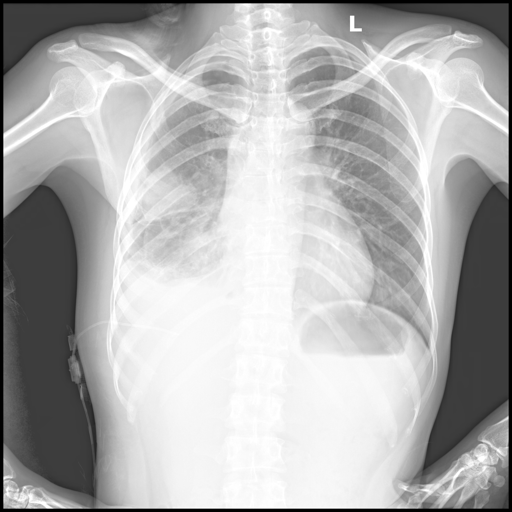

In [19]:
# Load the abnormal chest X-ray image
abnormal_chest_image = Image.open('abnormal_chest.png')
# The image is too big to comfortably displayed, Adjust some display to make it easier to read the notebook.
from IPython.display import display_png, Image as IPImage
display_png(IPImage('abnormal_chest.png', width=500))

## Step 3: Preprocess and prepare the Image

Next, we will preprocess the image using the `ruok_preprocess` class. This involves several steps including resizing, CLAHE, and thorax mask application. Finally prepare the image for the model.

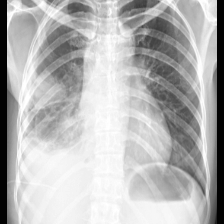

In [20]:
# Initialize the preprocessing class
preprocess = ruok_preprocess()

# Preprocess the abnormal chest X-ray image
preprocessed_abnormal_chest_image = preprocess(abnormal_chest_image)
# Display the preprocessed image
preprocessed_abnormal_chest_image

In [21]:
# Convert the preprocessed image to a batched numpy array
batched_numpy_image = ToTensor()(preprocessed_abnormal_chest_image).unsqueeze(0).cpu().numpy()

## Step 4: Load the ONNX Model and Run Inference

We will load the ONNX model using `onnxruntime` and run inference on the preprocessed image to generate the heatmap.

In [23]:
class_names = ['NF', 'STB', 'CA Lung', 'Heart and Mediastinum', 'Intra', 'Pneumonia', 'COVID-19', 'Extra']

In [22]:
# Load the ONNX model
ruokv1_ort_session = ort.InferenceSession("weights/ruokv1_heatmap.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

# Run inference
logits, _ = ruokv1_ort_session.run(None, {'input': batched_numpy_image})

In [26]:
# Apply sigmoid function to logits
sigmoid_logits = 1 / (1 + np.exp(-logits))
print("Sigmoid logits:", dict(zip(class_names, sigmoid_logits[0])))

Sigmoid logits: {'NF': 0.95144415, 'STB': 0.107218094, 'CA Lung': 0.24908358, 'Heart and Mediastinum': 0.09218073, 'Intra': 0.8404548, 'Pneumonia': 0.6652023, 'COVID-19': 0.7010704, 'Extra': 0.06949347}
